In [1]:
import python_utils.python_utils.caching as caching
import data_run.salary_run.salary_run.constants as constants
caching.init(constants.cache_folder, constants.which_hash)
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display_pretty, display_html
import python_utils.python_utils.basic as basic
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mpl_colors
import matplotlib.cm as cm
import pdb
import numpy as np
import scipy
#import ml_stuff.ml_stuff.hier_variational_regr as hvr
import causal_frl.causal_frl.hier_treatment_variational_regr as hvr
#import data.NSW.NSW.constants as data_constants
import data.salary.salary.fxns as data_fxns
import itertools
import python_utils.python_utils.features as features
from sklearn.pipeline import Pipeline
import python_utils.python_utils.sklearn_utils as sklearn_utils
import functools
import python_utils.python_utils.basic as basic

/Users/fultonw/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: mvtnorm

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/fultonw/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: Matrix

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/fultonw/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: stats4

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/fultonw/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: gmm

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/fultonw/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: Use

In [3]:
# retrieve raw data
raw_data = data_fxns.salary_df()
print raw_data.shape
raw_data.head()

(149642, 17)


,age,citizenship,country,education,employer_size,fulltime,gender,hourly_wage,household_summary,industry,marital,occupation,race,tax,union,weeks_worked,workclass
2,48,1,57,39,0,0,2,0,1,0,5,0,1,6,0,0,5
5,65,1,57,43,2,2,2,0,1,18,4,1,1,4,0,48,1
6,10,1,57,0,0,0,2,0,6,0,7,0,1,6,0,0,0
9,25,1,57,43,6,2,2,0,1,13,7,5,1,5,0,50,1
12,21,1,57,39,4,2,1,0,1,18,7,9,1,5,0,52,1


In [4]:
# filter raw data
def scale_salary(df):
    df.hourly_wage = df.hourly_wage / 100.
    return df
rows_to_keep = 20000
preprocess_pipeline = Pipeline([\
                                ('has_salary', sklearn_utils.transform_from_fxn(lambda df: df[df.hourly_wage>.001])),\
                                ('scale_salary',sklearn_utils.transform_from_fxn(scale_salary)),\
#                                ('truncate',sklearn_utils.transform_from_fxn(lambda df:df.iloc[0:rows_to_keep,:])),\
                                ])
data = preprocess_pipeline.transform(raw_data)
print data.shape
data.head()

(8462, 17)


/Users/fultonw/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/pandas/core/generic.py:1974: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,age,citizenship,country,education,employer_size,fulltime,gender,hourly_wage,household_summary,industry,marital,occupation,race,tax,union,weeks_worked,workclass
39,42,1,57,40,6,2,2,17.89,1,7,5,5,1,4,1,52,1
45,46,1,57,43,1,1,2,7.00,2,10,1,4,1,1,2,40,1
66,54,1,57,40,5,2,2,13.50,2,17,1,2,1,1,2,40,1
73,49,1,57,43,6,2,1,17.00,1,11,1,5,1,1,2,52,1
74,47,1,57,40,5,2,2,9.00,2,18,1,5,1,1,2,45,2


In [5]:
# extract data for categorical features.  this is used as input for binary features from categorical ones, as well as gender
cat_feats_columns = ['citizenship','country','education','employer_size','fulltime','gender','household_summary','industry','marital','occupation','race','tax','union','workclass']
cat_feats_data = data[cat_feats_columns]

/Users/fultonw/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/tight_layout.py:225: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


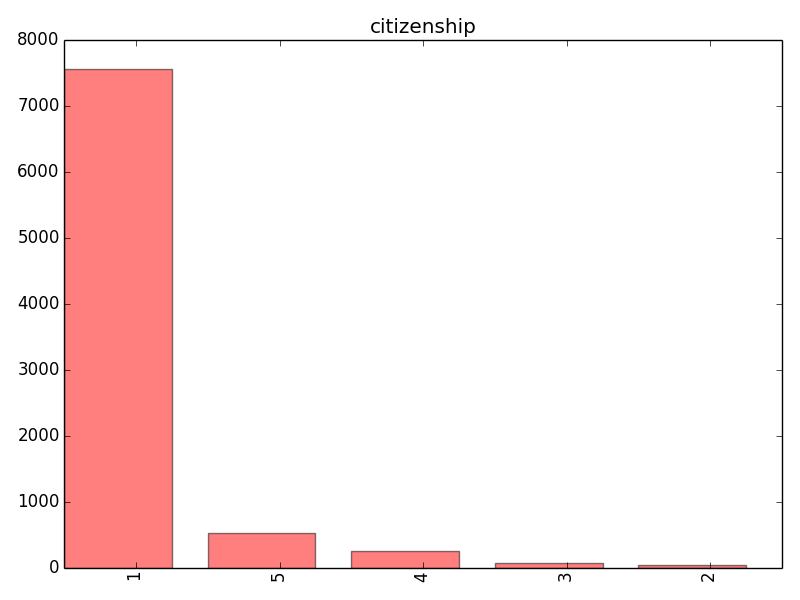

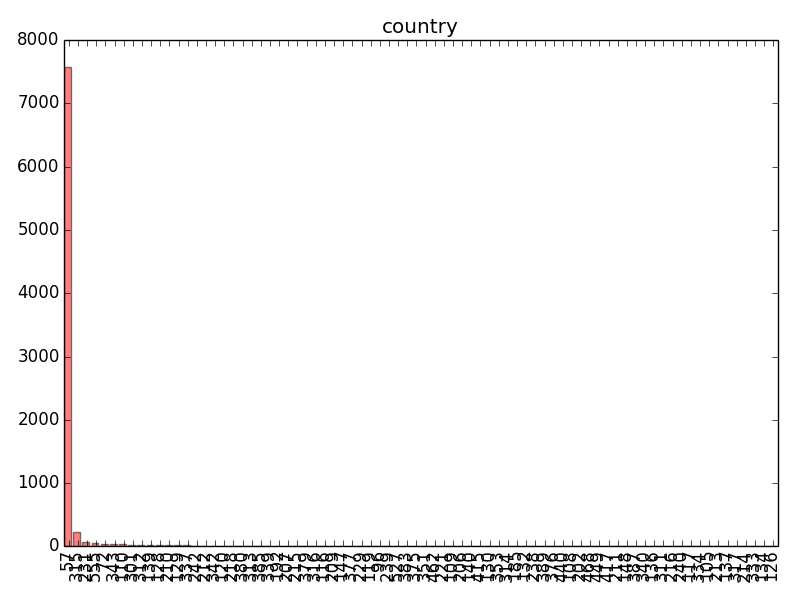

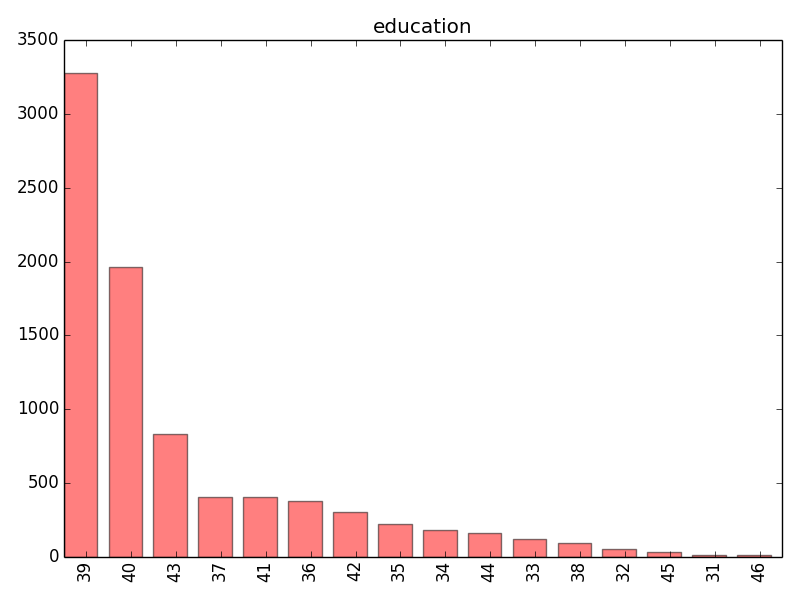

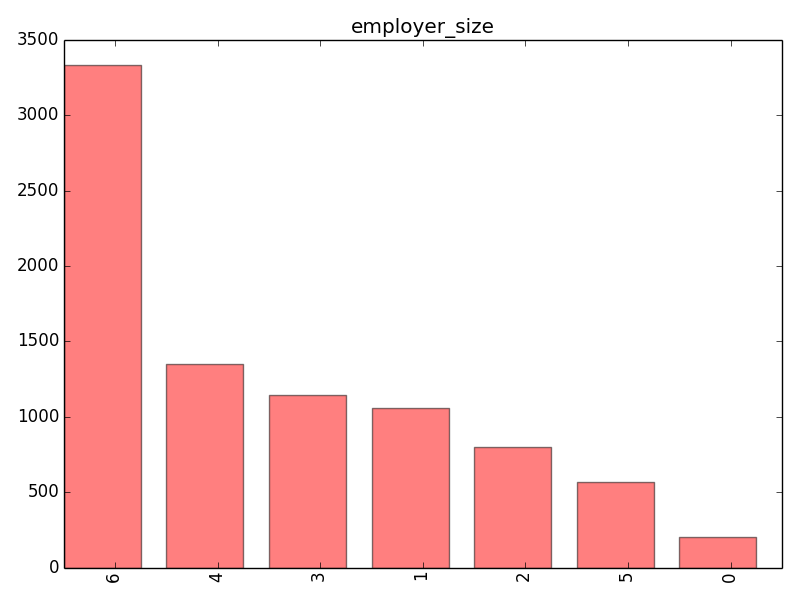

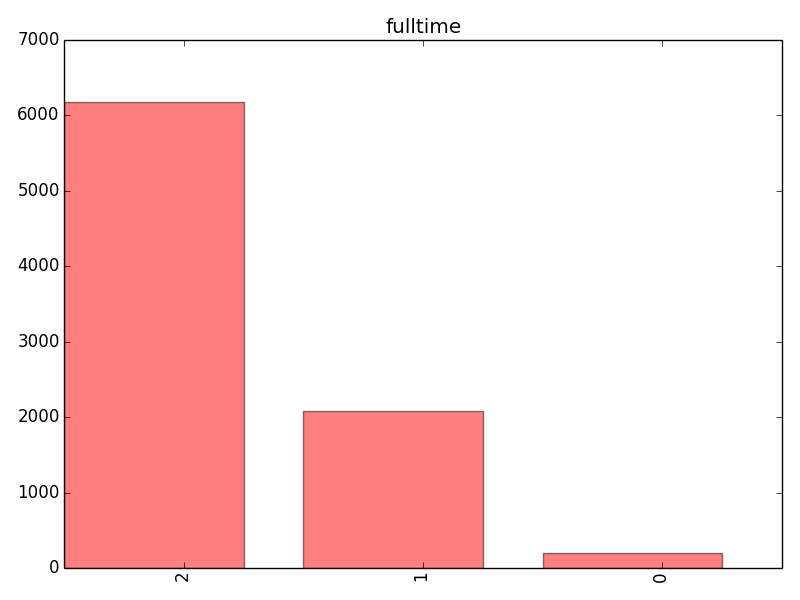

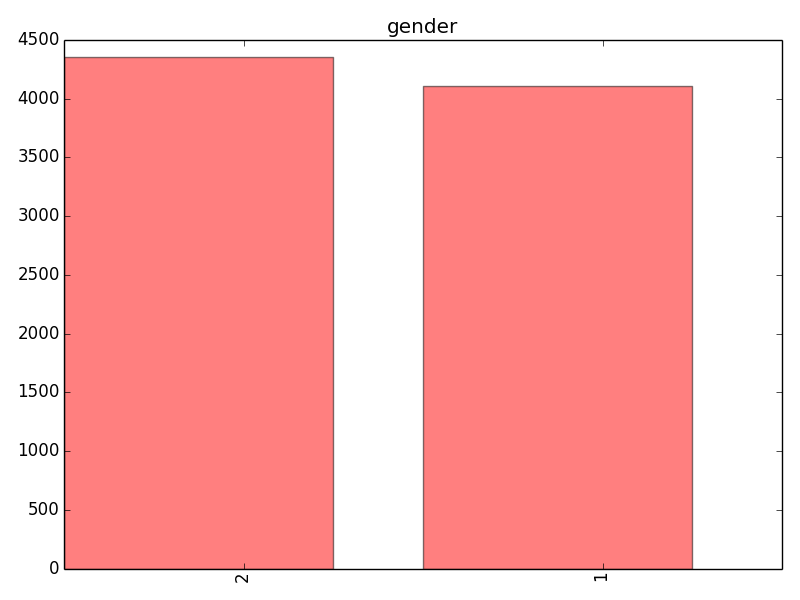

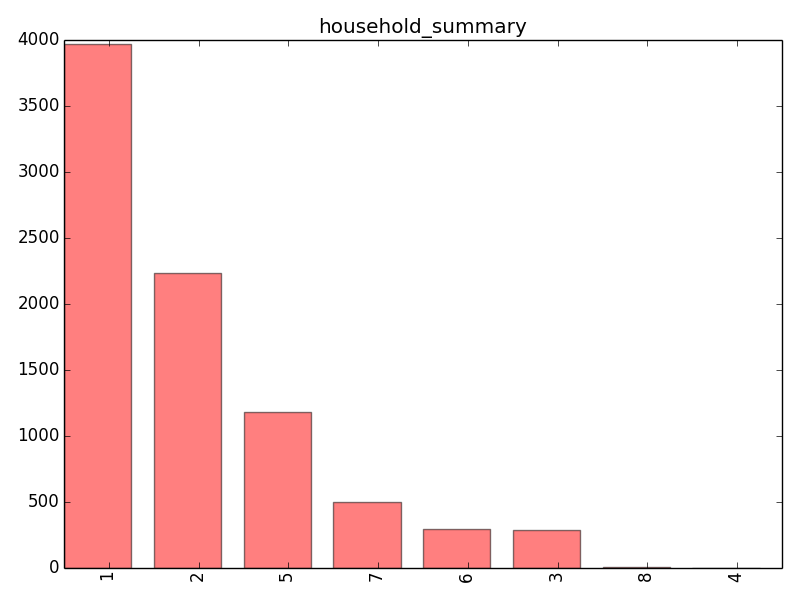

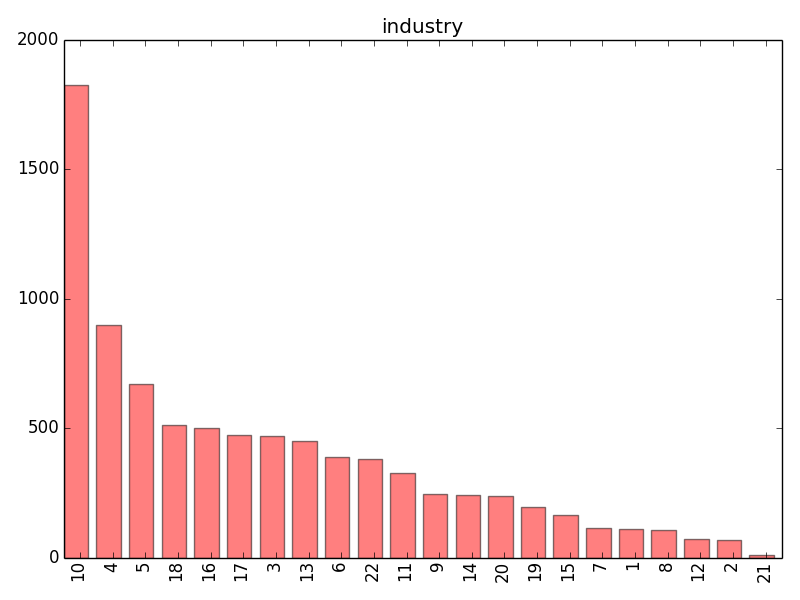

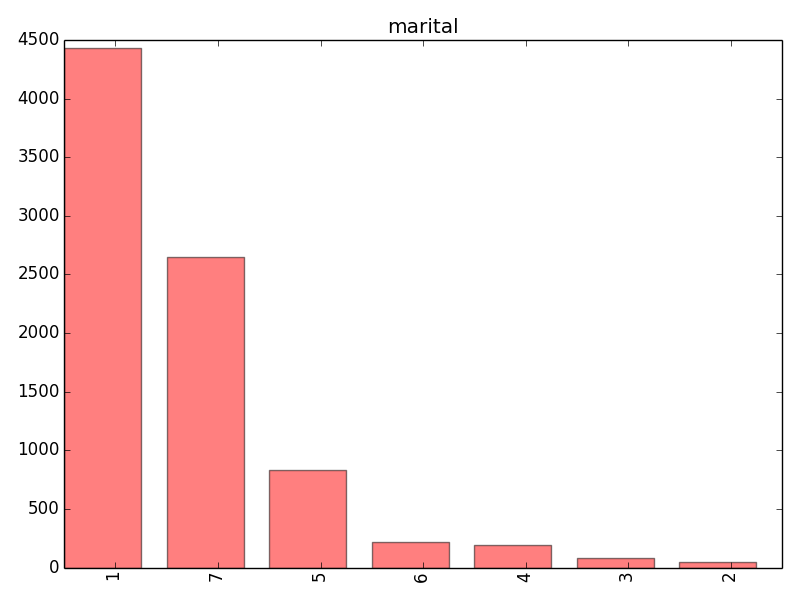

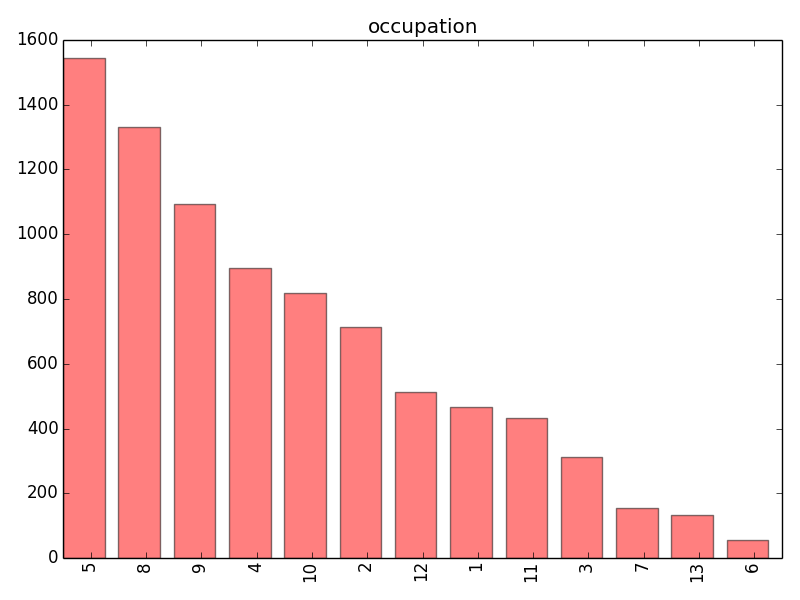

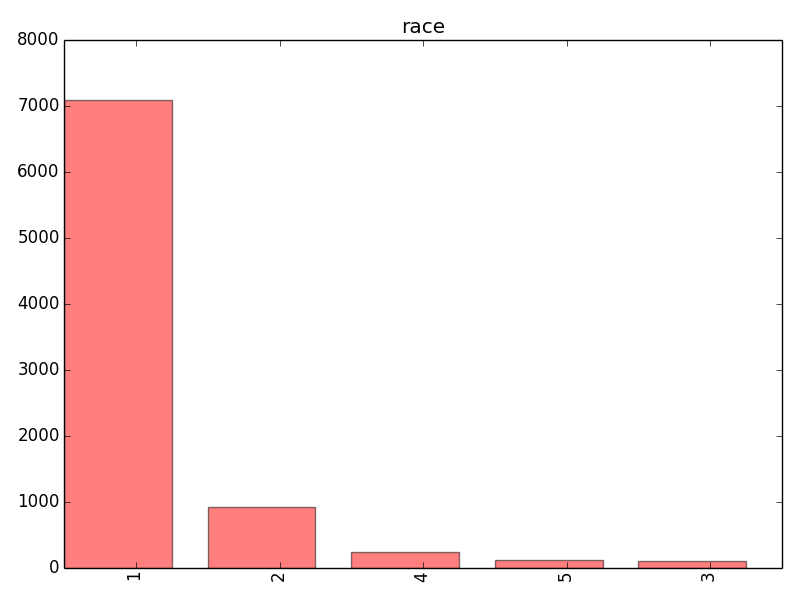

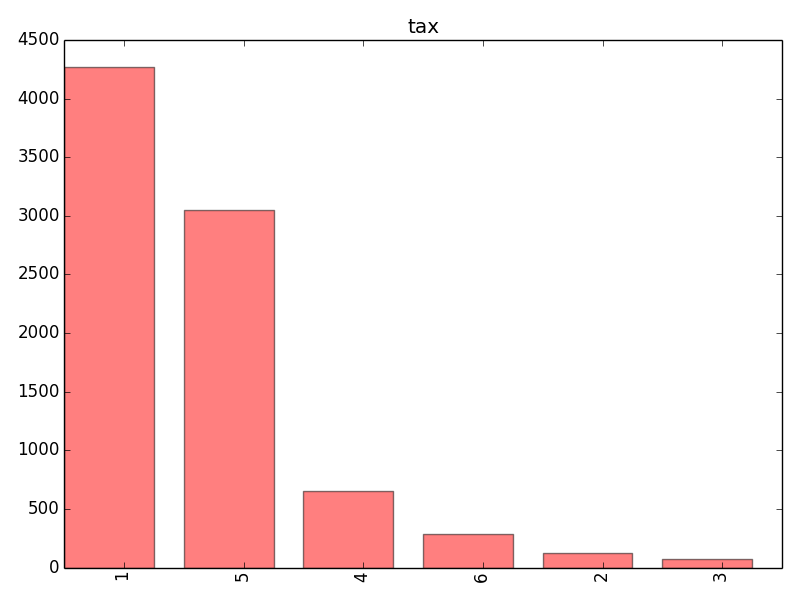

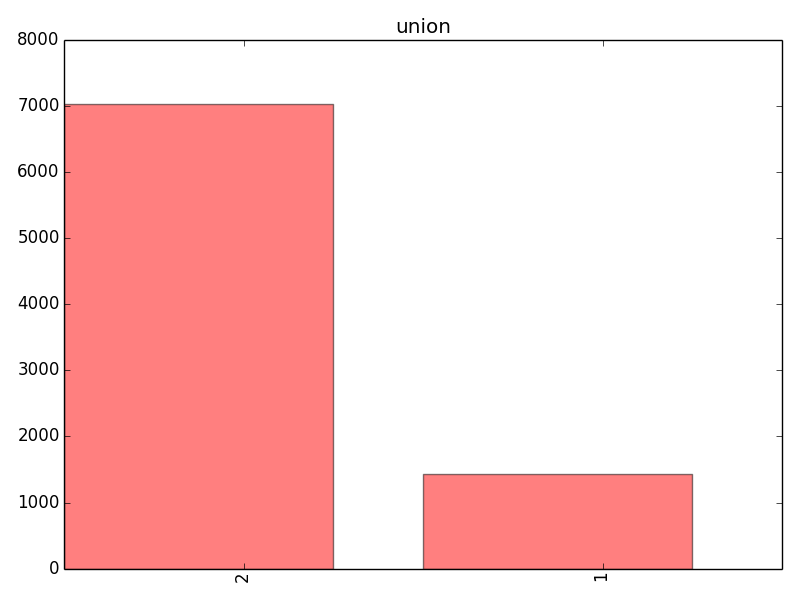

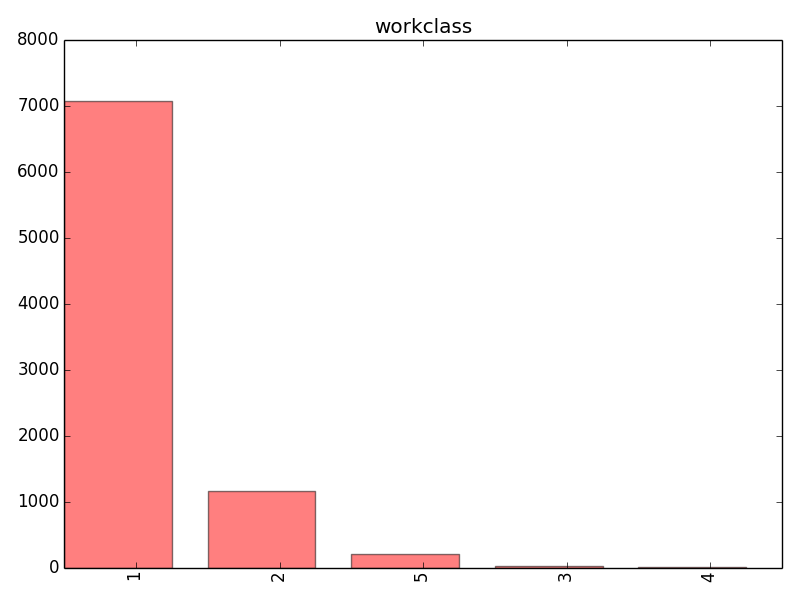

In [6]:
# exploratory: for categorical features, for each column, plot bar chart of counts
for (col_name,vals) in cat_feats_data.T.iterrows():
    fig, ax = plt.subplots()
    labels, counts = zip(*vals.value_counts().iteritems())
    basic.plot_bar_chart(ax, labels, counts, offset = 0, width = 0.75, label = None, alpha = 0.5, color = 'red')
    ax.set_title(col_name)
    fig.tight_layout()
    basic.display_fig_inline(fig)

In [7]:
# for categorical features, remap the levels to get another dataframe, then drop_NA
dff = features.df_feature_from_feature
remap_feats = [\
              dff(features.map_feature({\
                                       features.equals_bin(1):'M',\
                                       features.equals_bin(2):'F'}),'gender'),\
              dff(features.map_feature({\
                                        features.contains_bin([1,2,3]):'citizen',\
                                        features.equals_bin(4):'naturalized',\
                                        features.equals_bin(5):'not_citizen',\
                                       }),'citizenship'),\
              dff(features.map_feature({\
                                        features.interval_bin(31,35):'less_hs',\
                                        features.interval_bin(35,39):'some_hs',\
                                        features.equals_bin(39):'hs_grad',\
                                        features.equals_bin(40):'some_college',\
                                        features.interval_bin(41,43):'associates',\
                                        features.equals_bin(43):'bachelors',\
                                        features.equals_bin(44):'masters',\
                                        features.equals_bin(45):'prof_school',\
                                        features.equals_bin(46):'phd',\
                                       }),'education'),\
              dff(features.map_feature({\
                                        features.equals_bin(1):'None_10',\
                                        features.equals_bin(2):'10_24',\
                                        features.equals_bin(3):'25_99',\
                                        features.equals_bin(4):'100_499',\
                                        features.equals_bin(5):'500_999',\
                                        features.equals_bin(6):'1000_None',\
                                       }),'employer_size'),\
              dff(features.map_feature({\
                                        features.equals_bin(1):'part_time',\
                                        features.equals_bin(2):'full_time',\
                                       }),'fulltime'),\
              dff(features.map_feature({\
                                        features.equals_bin(1):'householder',\
                                        features.equals_bin(2):'spouse_of_householder',\
                                        features.equals_bin(3):'child_under_18_single',\
                                        features.equals_bin(4):'child_under_18_married',\
                                        features.equals_bin(5):'child_over_18',\
                                        features.equals_bin(6):'other_relationship',\
                                        features.equals_bin(7):'group_quarters',\
                                       }),'household_summary'),\
               dff(features.map_feature({\
                                        features.equals_bin(1):'agriculture',\
                                        features.equals_bin(2):'mining',\
                                        features.equals_bin(3):'construction',\
                                        features.equals_bin(4):'manufacturing_durable',\
                                        features.equals_bin(5):'manufacturing_nondurable',\
                                        features.equals_bin(6):'transportation',\
                                        features.equals_bin(7):'communications',\
                                        features.equals_bin(8):'utilities',\
                                        features.equals_bin(9):'wholesale_trade',\
                                        features.equals_bin(10):'retail_trade',\
                                        features.equals_bin(11):'finance_insurance',\
                                        features.equals_bin(12):'private_household_service',\
                                        features.equals_bin(13):'business_repair',\
                                        features.equals_bin(14):'other_private_service',\
                                        features.equals_bin(15):'entertainment',\
                                        features.equals_bin(16):'hospital',\
                                        features.equals_bin(17):'medical',\
                                        features.equals_bin(18):'educational',\
                                        features.equals_bin(19):'social_service',\
                                        features.equals_bin(20):'other_service',\
                                        features.equals_bin(21):'forestry_fisheries',\
                                        features.equals_bin(22):'public_admin',\
                                       }),'industry'),\
#              dff(features.map_feature({\
#                                        features.interval_bin(10,31):'agriculture',\
#                                        features.interval_bin(40,51):'mining',\
#                                        features.equals_bin(60):'construction',\
#                                        features.interval_bin(230,393):'manufacturing_durable',\
#                                        features.interval_bin(100,223):'manufacturing_non_durable',\
#                                        features.interval_bin(400,443):'transportation',\
#                                        features.interval_bin(440,443):'communication_utilities',\
#                                        features.interval_bin(450,473):'other_utilities',\
#                                        features.interval_bin(500,572):'wholesale_trade',\
#                                        features.interval_bin(580,692):'retail_trade',\
#                                        features.interval_bin(700,713):'finance_real_estate',\
#                                        features.equals_bin(761):'private_service',\
#                                        features.interval_bin(721,761):'business_service',\
#                                        features.interval_bin(762,792):'personal_service',\
#                                        features.interval_bin(800,811):'entertainment_service',\
#                                        features.equals_bin(831):'hospital_service',\
#                                        features.union_bin([features.interval_bin(812,831),features.interval_bin(832,841)]):'medical_service',\
#                                        features.interval_bin(842,861):'educational_service',\
#                                        features.interval_bin(861,872):'social_service',\
#                                        features.union_bin([features.equals_bin(841),features.interval_bin(872,894)]):'other_service',\
#                                        features.interval_bin(900,933):'public_administration',\
#                                       }),'industry'),\
              dff(features.map_feature({\
                                        features.equals_bin(1):'civilian_spouse',\
                                        features.equals_bin(2):'armed_spouse',\
                                        features.equals_bin(3):'married_separated',\
                                        features.equals_bin(4):'widowed',\
                                        features.equals_bin(5):'divorced',\
                                        features.equals_bin(6):'separated',\
                                        features.equals_bin(7):'never_married',\
                                       }),'marital'),\
              dff(features.map_feature({\
                                        features.equals_bin(1):'executive',\
                                        features.equals_bin(2):'professional_specialty',\
                                        features.equals_bin(3):'technician',\
                                        features.equals_bin(4):'sales',\
                                        features.equals_bin(5):'administrative',\
                                        features.equals_bin(6):'private_service',\
                                        features.equals_bin(7):'protective_service',\
                                        features.equals_bin(8):'other_service',\
                                        features.equals_bin(9):'skilled_tech_service',\
                                        features.equals_bin(10):'factory',\
                                        features.equals_bin(11):'transportation',\
                                        features.equals_bin(12):'handler_equip_cleaner',\
                                        features.equals_bin(13):'farming_forestry',\
                                        features.equals_bin(14):'armed_forces',\
                                       }),'occupation'),\
              dff(features.map_feature({\
                                        features.equals_bin(1):'white',\
                                        features.equals_bin(2):'black',\
                                        features.equals_bin(3):'american_indian',\
                                        features.equals_bin(4):'asian',\
                                        features.equals_bin(5):'other',\
                                       }),'race'),\
              dff(features.map_feature({\
                                        features.equals_bin(1):'joint_lt_65_lt_65',\
                                        features.equals_bin(2):'joint_lt_65_gt_65',\
                                        features.equals_bin(3):'joint_gt_65_gt_65',\
                                        features.equals_bin(4):'head',\
                                        features.equals_bin(5):'single',\
                                        features.equals_bin(6):'non_filer',\
                                       }),'tax'),\
              dff(features.map_feature({\
                                        features.equals_bin(1):'yes',\
                                        features.contains_bin([0,2]):'no',\
                                       }),'union'),\
              dff(features.map_feature({\
                                        features.equals_bin(1):'private',\
                                        features.equals_bin(2):'government',\
                                        features.equals_bin(3):'self',\
                                        features.equals_bin(4):'no_pay',\
                                       }),'workclass'),\
              ]
remap_feats_pipeline = Pipeline([\
                                ('remap', sklearn_utils.transform_from_fxn(functools.partial(features.df_from_df_and_df_features, remap_feats))),\
                                ('drop_na', sklearn_utils.transform_from_fxn(lambda df: df.dropna(axis=0,how='any'))),\
                                ])
remap_feats_data = remap_feats_pipeline.transform(data)
#remap_feats_data = remap_feats_data.dropna(axis=0,how='any')
print remap_feats_data.shape
remap_feats_data.head(10)
#remap_feats_data.apply(lambda col:col.isnull().sum(),axis=0)

(8254, 13)


,gender,citizenship,education,employer_size,fulltime,household_summary,industry,marital,occupation,race,tax,union,workclass
39,F,citizen,some_college,1000_None,full_time,householder,communications,divorced,administrative,white,head,yes,private
45,F,citizen,bachelors,None_10,part_time,spouse_of_householder,retail_trade,civilian_spouse,sales,white,joint_lt_65_lt_65,no,private
66,F,citizen,some_college,500_999,full_time,spouse_of_householder,medical,civilian_spouse,professional_specialty,white,joint_lt_65_lt_65,no,private
73,M,citizen,bachelors,1000_None,full_time,householder,finance_insurance,civilian_spouse,administrative,white,joint_lt_65_lt_65,no,private
74,F,citizen,some_college,500_999,full_time,spouse_of_householder,educational,civilian_spouse,administrative,white,joint_lt_65_lt_65,no,government
75,F,citizen,some_college,None_10,part_time,child_over_18,retail_trade,never_married,sales,white,single,no,private
76,F,citizen,some_hs,1000_None,part_time,child_under_18_single,retail_trade,never_married,sales,white,single,no,private
108,F,citizen,associates,1000_None,full_time,householder,medical,civilian_spouse,technician,white,joint_lt_65_lt_65,no,private
257,F,citizen,some_college,100_499,full_time,householder,other_service,widowed,administrative,white,single,no,private
261,M,citizen,hs_grad,10_24,full_time,child_over_18,wholesale_trade,never_married,executive,white,single,no,private


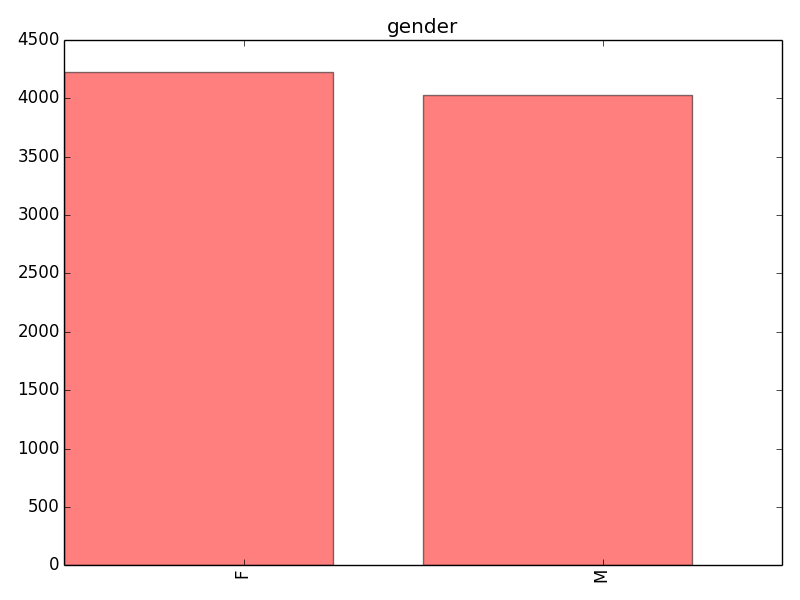

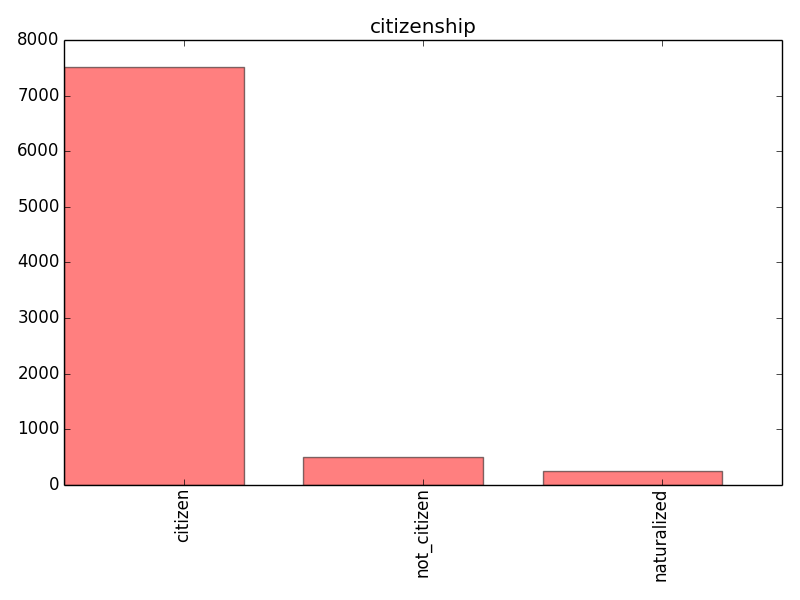

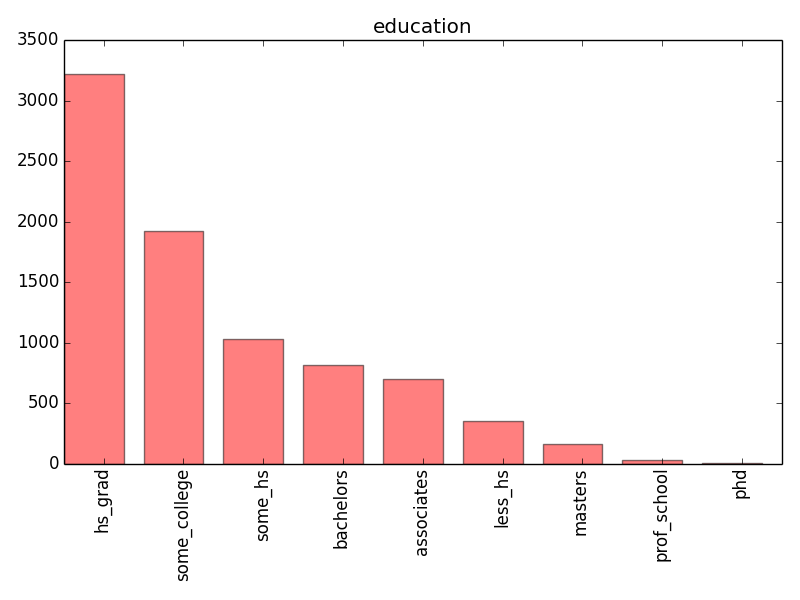

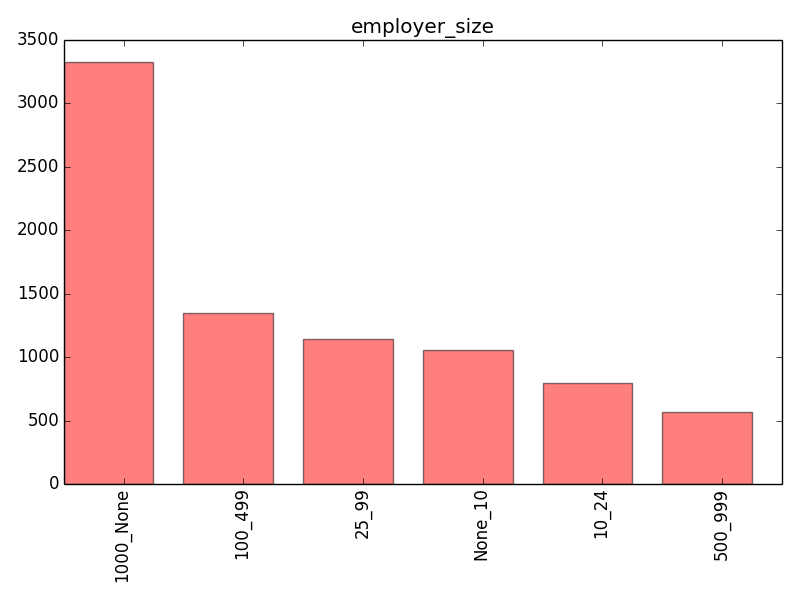

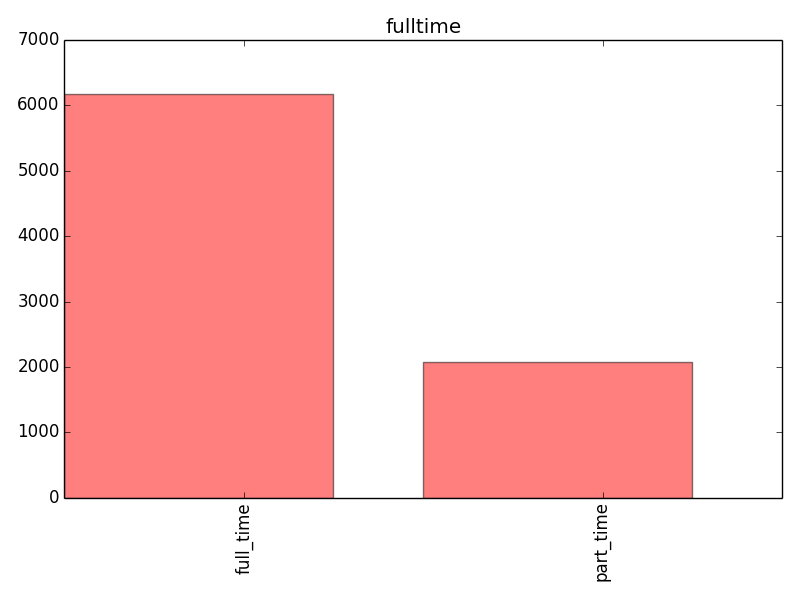

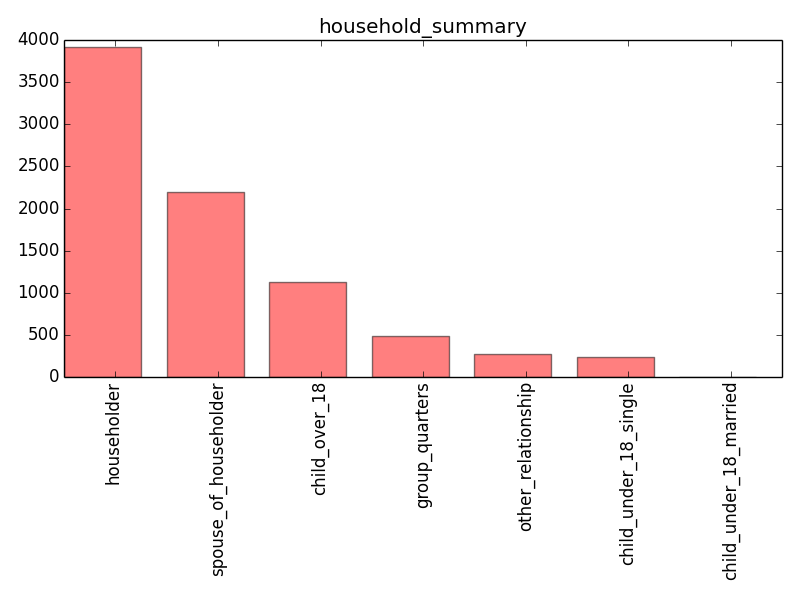

/Users/fultonw/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/pyplot.py:412: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_num_figures`).
  max_open_warning, RuntimeWarning)


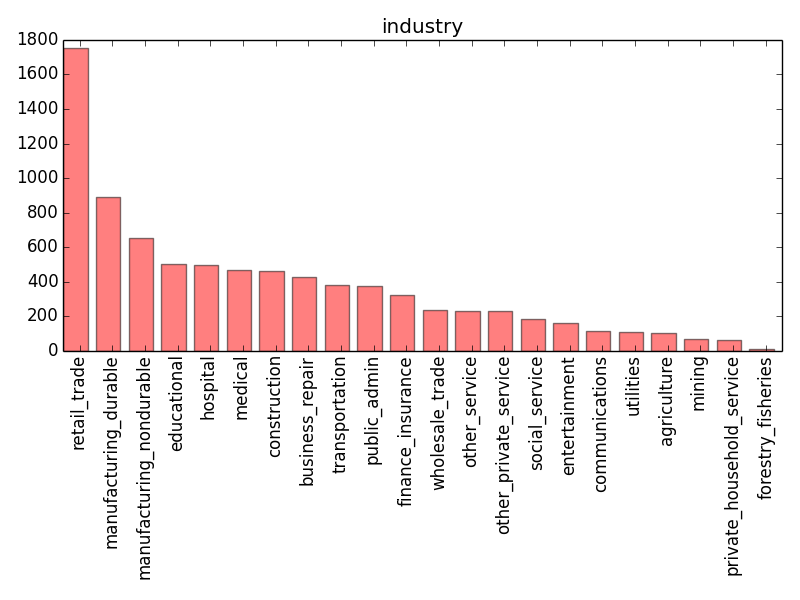

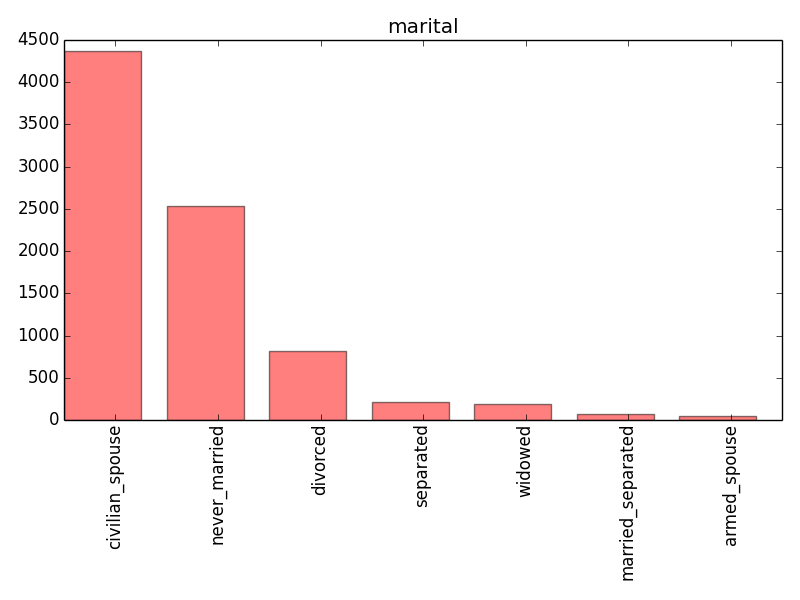

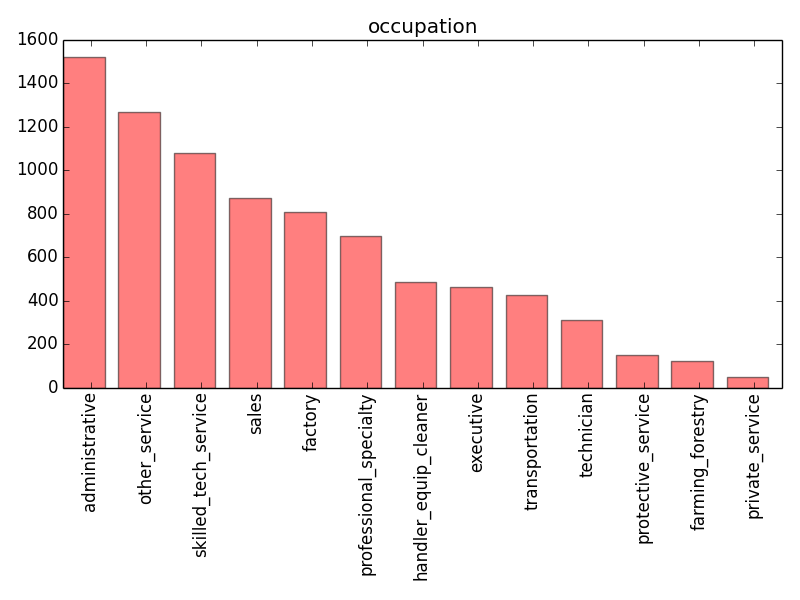

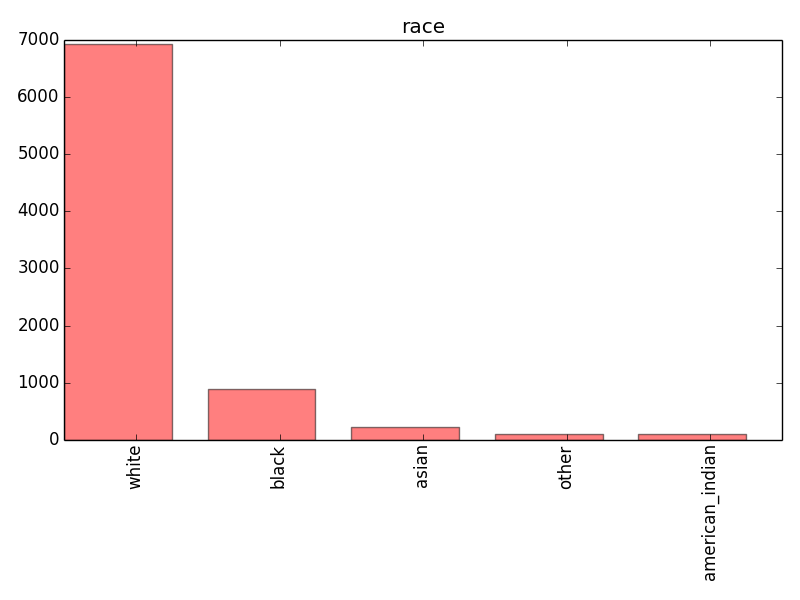

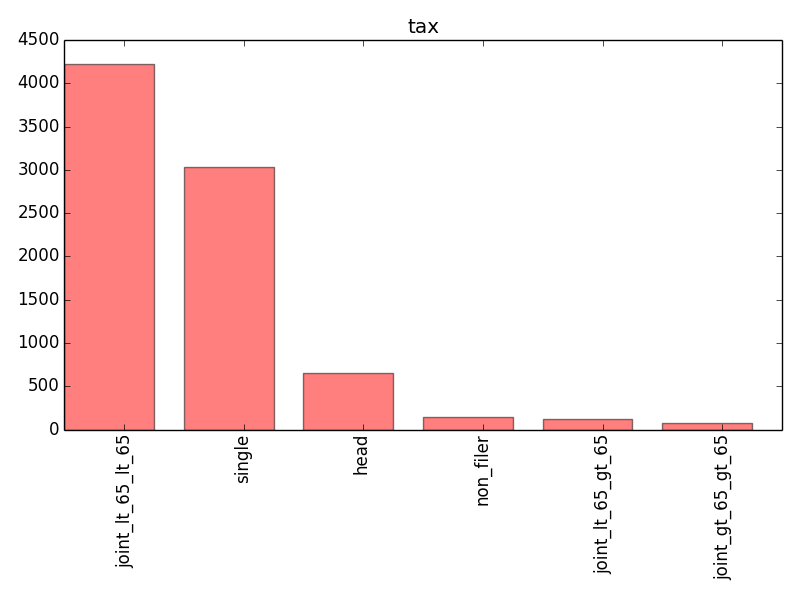

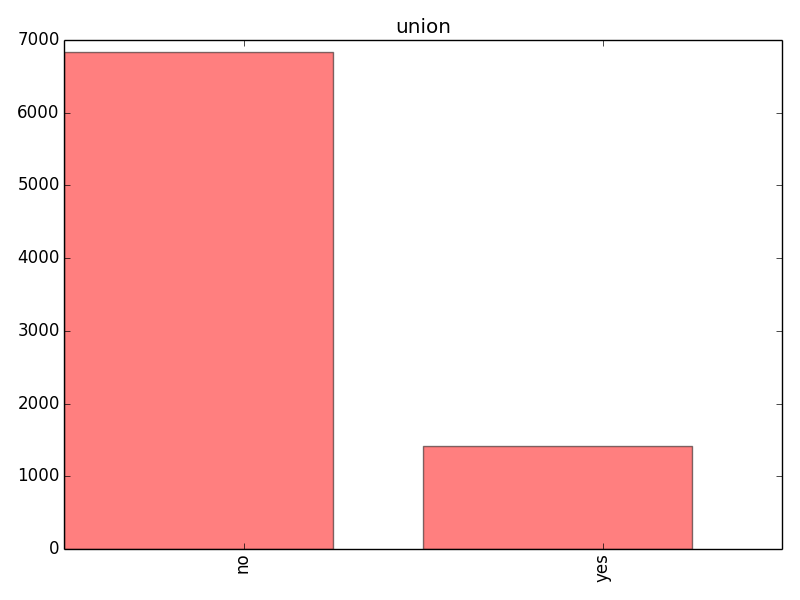

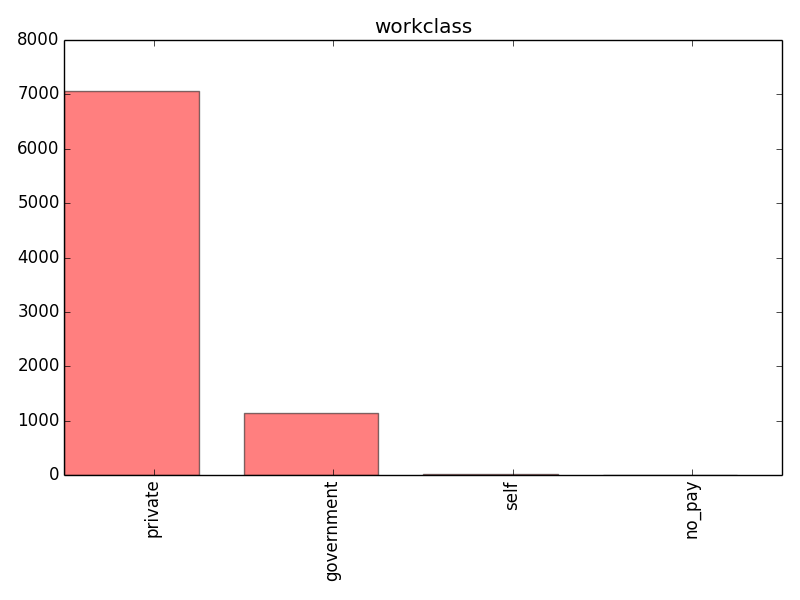

In [8]:
# for categorical features, for each column, plot bar chart of counts
for (col_name,vals) in remap_feats_data.T.iterrows():
    fig, ax = plt.subplots()
    labels, counts = zip(*vals.value_counts().iteritems())
    basic.plot_bar_chart(ax, labels, counts, offset = 0, width = 0.75, label = None, alpha = 0.5, color = 'red')
    ax.set_title(col_name)
    fig.tight_layout()
    basic.display_fig_inline(fig)

In [9]:
# for categorical features, bin them further to get their binary features
cat_feats_bin_feats = [\
                       dff(features.bins_feature([features.equals_bin('citizen')], not_others=True),'citizenship'),\
                       dff(features.bins_feature([features.contains_bin(['bachelors','masters'])], not_others=True),'education'),\
                       dff(features.bins_feature([features.equals_bin('1000_None'),features.equals_bin('None_10')], not_others=True),'employer_size'),\
                       dff(features.bins_feature([features.equals_bin('full_time'),], not_others=True),'fulltime'),\
                       dff(features.bins_feature([features.equals_bin('householder'),], not_others=True),'household_summary'),\
                       dff(features.bins_feature([features.contains_bin(['agriculture','entertainment','finance_insurance','hospital']),features.not_bin(features.contains_bin(['manufacturing_durable','manufacturing_nondurable'])),], not_others=True),'industry'),\
                       dff(features.bins_feature([features.equals_bin('marital_spouse'),], not_others=True),'marital'),\
                       dff(features.bins_feature([features.contains_bin(['executive','protective_service']),features.contains_bin(['farming_forestry','private_service','transportation']),], not_others=True),'occupation'),\
                       dff(features.bins_feature([features.equals_bin('white'),features.equals_bin('black')], not_others=True),'race'),\
                       dff(features.bins_feature([features.equals_bin('joint_lt_65_lt_65'),], not_others=True),'tax'),\
                       dff(features.bins_feature([features.equals_bin('no'),], not_others=True),'union'),\
                       dff(features.bins_feature([features.equals_bin('private'),], not_others=True),'workclass'),\
#                       features.empirical_cat_df_feature('citizenship')        
               ]
cat_feats_bin_feats_pipeline = Pipeline([\
                                ('remap', sklearn_utils.transform_from_fxn(functools.partial(features.df_from_df_and_df_features, cat_feats_bin_feats))),\
                                ])
cat_feats_bin_feats_data = cat_feats_bin_feats_pipeline.transform(remap_feats_data)
print cat_feats_bin_feats_data.shape
cat_feats_bin_feats_data.head(10)

(8254, 28)


,citizenship_equals_'citizen',citizenship_none_of,"education_['bachelors', 'masters']",education_none_of,employer_size_equals_'1000_None',employer_size_equals_'None_10',employer_size_none_of,fulltime_equals_'full_time',fulltime_none_of,household_summary_equals_'householder',...,occupation_none_of,race_equals_'white',race_equals_'black',race_none_of,tax_equals_'joint_lt_65_lt_65',tax_none_of,union_equals_'no',union_none_of,workclass_equals_'private',workclass_none_of
39,1,0,0,1,1,0,0,1,0,1,...,1,1,0,0,0,1,0,1,1,0
45,1,0,1,0,0,1,0,0,1,0,...,1,1,0,0,1,0,1,0,1,0
66,1,0,0,1,0,0,1,1,0,0,...,1,1,0,0,1,0,1,0,1,0
73,1,0,1,0,1,0,0,1,0,1,...,1,1,0,0,1,0,1,0,1,0
74,1,0,0,1,0,0,1,1,0,0,...,1,1,0,0,1,0,1,0,0,1
75,1,0,0,1,0,1,0,0,1,0,...,1,1,0,0,0,1,1,0,1,0
76,1,0,0,1,1,0,0,0,1,0,...,1,1,0,0,0,1,1,0,1,0
108,1,0,0,1,1,0,0,1,0,1,...,1,1,0,0,1,0,1,0,1,0
257,1,0,0,1,0,0,1,1,0,1,...,1,1,0,0,0,1,1,0,1,0
261,1,0,0,1,0,0,1,1,0,0,...,0,1,0,0,0,1,1,0,1,0


In [10]:
# for categorical features, print counts of each binary features
cat_feats_bin_feats_data.sum(axis=0)

citizenship_equals_'citizen'                                    7506
citizenship_none_of                                              748
education_['bachelors', 'masters']                               981
education_none_of                                               7273
employer_size_equals_'1000_None'                                3328
employer_size_equals_'None_10'                                  1060
employer_size_none_of                                           3866
fulltime_equals_'full_time'                                     6177
fulltime_none_of                                                2077
household_summary_equals_'householder'                          3918
household_summary_none_of                                       4336
industry_['agriculture', 'entertainment', 'finance_insurance', 'hospital']    1088
industry_not_['manufacturing_durable', 'manufacturing_nondurable']    6708
industry_none_of                                                1546
marital_equals

In [11]:
# get gender series
gender = remap_feats_data['gender']

In [12]:
# extract relevant columns for scalar features
scalar_columns = [\
                  'age',\
                  'weeks_worked',\
                  'hourly_wage',\
                 ]
scalar_feats_data = data[scalar_columns]

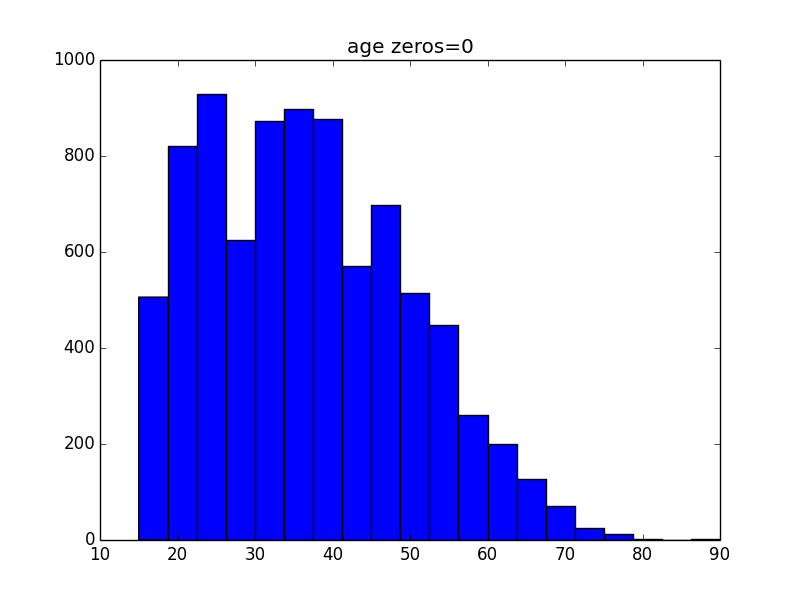

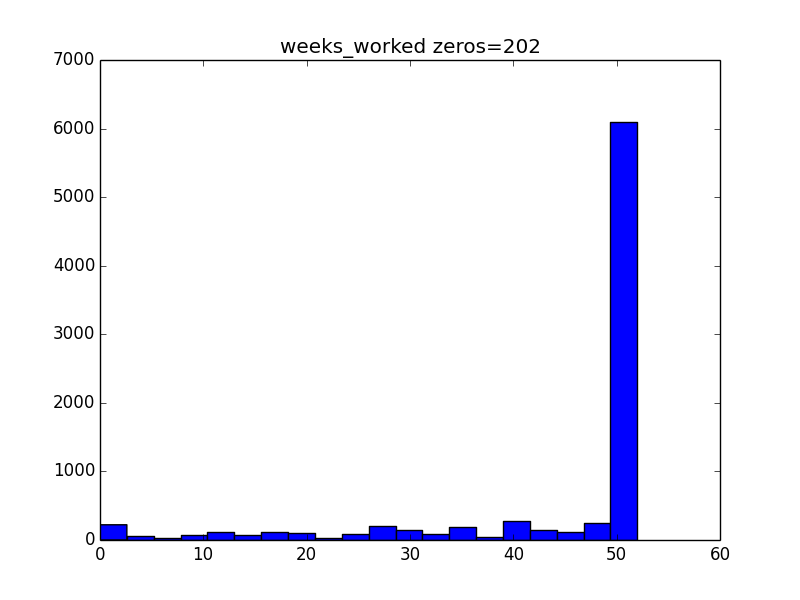

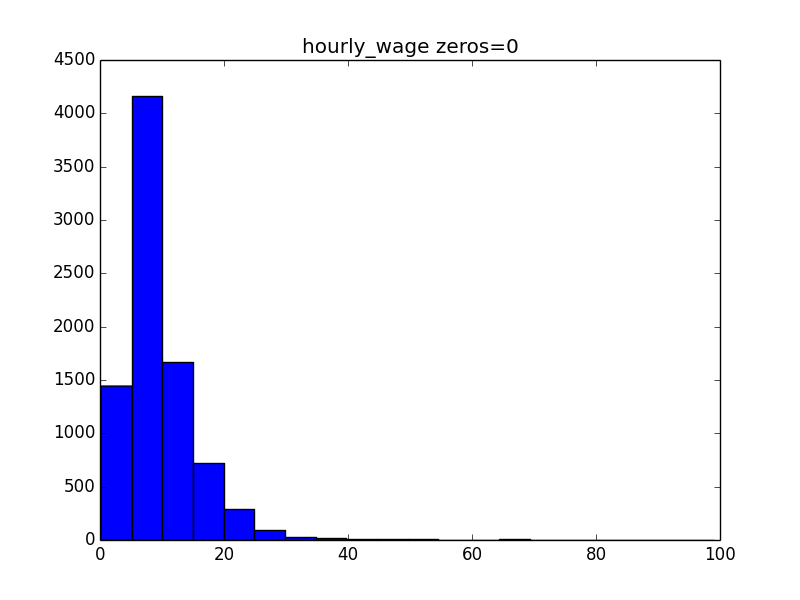

In [13]:
# for each scalar column, plot histogram
for (col_name,vals) in scalar_feats_data.T.iterrows():
    fig,ax = plt.subplots()
    num_zeros = (vals < .0001).sum()
    ax.set_title('%s zeros=%d' % (col_name, num_zeros))
    ax.hist(vals.values,bins=20)
    basic.display_fig_inline(fig)

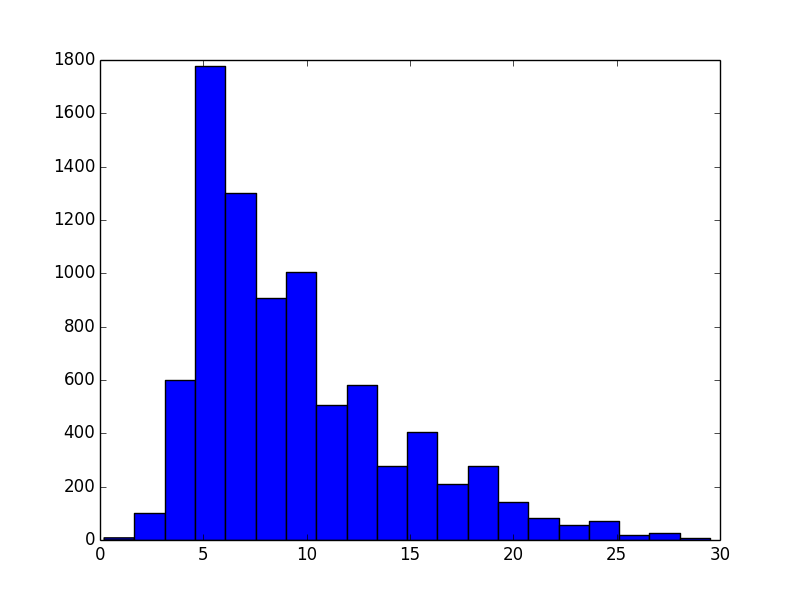

In [14]:
# look at distribution of wage more closely
fig, ax = plt.subplots()
ax.hist(scalar_feats_data.hourly_wage[(scalar_feats_data.hourly_wage<30) & (scalar_feats_data.hourly_wage > .001)].values,bins=20)
basic.display_fig_inline(fig)

In [15]:
# get binary features based on scalar data (filter it first)
scalar_feats_bin_feats = [\
               dff(features.bins_feature.from_boundaries([18,25,40,60,None],drop=False),'age'),\
#               dff(features.bins_feature.from_boundaries([0,1,50,None],drop=False),'weeks_worked'),\
               ]
scalar_feats_bin_feats_pipeline = Pipeline([\
                                            ('worked_enough',sklearn_utils.transform_from_fxn(lambda df:df[df.weeks_worked>25.])),\
                                            ('remap', sklearn_utils.transform_from_fxn(functools.partial(features.df_from_df_and_df_features, scalar_feats_bin_feats))),\
                                           ])
scalar_feats_bin_feats_data = scalar_feats_bin_feats_pipeline.transform(scalar_feats_data)
print scalar_feats_bin_feats_data.shape
scalar_feats_bin_feats_data.head(10)

(7552, 4)


,age_bin_18_25,age_bin_25_40,age_bin_40_60,age_bin_60_None
39,0,0,1,0
45,0,0,1,0
66,0,0,1,0
73,0,0,1,0
74,0,0,1,0
75,1,0,0,0
108,0,1,0,0
257,0,0,0,1
261,1,0,0,0
269,0,1,0,0


In [16]:
# for scalar features, print counts of each binary features
scalar_feats_bin_feats_data.sum(axis=0)

age_bin_18_25      1223
age_bin_25_40      3043
age_bin_40_60      2740
age_bin_60_None     391
dtype: float64

In [17]:
# get hourly wage
wage = scalar_feats_data['hourly_wage']

In [18]:
# get one big dataframe from which to extract raw input
all_data = pd.concat([\
                              cat_feats_bin_feats_data,\
                              scalar_feats_bin_feats_data,\
                              pd.DataFrame({'hourly_wage':wage,'gender':gender}),\
                             ], join='inner', axis=1)
print all_data.shape
all_data.head()

(7548, 34)


,citizenship_equals_'citizen',citizenship_none_of,"education_['bachelors', 'masters']",education_none_of,employer_size_equals_'1000_None',employer_size_equals_'None_10',employer_size_none_of,fulltime_equals_'full_time',fulltime_none_of,household_summary_equals_'householder',...,union_equals_'no',union_none_of,workclass_equals_'private',workclass_none_of,age_bin_18_25,age_bin_25_40,age_bin_40_60,age_bin_60_None,gender,hourly_wage
39,1,0,0,1,1,0,0,1,0,1,...,0,1,1,0,0,0,1,0,F,17.89
45,1,0,1,0,0,1,0,0,1,0,...,1,0,1,0,0,0,1,0,F,7.00
66,1,0,0,1,0,0,1,1,0,0,...,1,0,1,0,0,0,1,0,F,13.50
73,1,0,1,0,1,0,0,1,0,1,...,1,0,1,0,0,0,1,0,M,17.00
74,1,0,0,1,0,0,1,1,0,0,...,1,0,0,1,0,0,1,0,F,9.00


In [20]:
# convert dataframe to method input
x_ns = all_data.iloc[:,0:-2].values
x_names = all_data.columns[0:-2]
T_ns = (all_data.gender == 'M').values
y_ns = all_data.hourly_wage.values
K = x_ns.shape[1]

In [21]:
# mine rules
all_rule_fs = hvr.fpgrowth_miner_f(supp=10, zmax=2)(x_ns, x_names)
for rule in all_rule_fs:
    print rule
print 'number of rules mined: %d' % len(all_rule_fs)

bin["citizenship_equals_'citizen'" 'marital_none_of']_1
bin["citizenship_equals_'citizen'"]_1
bin['education_none_of' "citizenship_equals_'citizen'"]_1
bin['education_none_of' 'marital_none_of']_1
bin['education_none_of']_1
bin["workclass_equals_'private'" "citizenship_equals_'citizen'"]_1
bin["workclass_equals_'private'" 'education_none_of']_1
bin["workclass_equals_'private'" 'marital_none_of']_1
bin["workclass_equals_'private'"]_1
bin['occupation_none_of' "citizenship_equals_'citizen'"]_1
bin['occupation_none_of' 'education_none_of']_1
bin['occupation_none_of' "workclass_equals_'private'"]_1
bin['occupation_none_of' 'marital_none_of']_1
bin['occupation_none_of']_1
bin["race_equals_'white'" "citizenship_equals_'citizen'"]_1
bin["race_equals_'white'" 'education_none_of']_1
bin["race_equals_'white'" "workclass_equals_'private'"]_1
bin["race_equals_'white'" 'occupation_none_of']_1
bin["race_equals_'white'" 'marital_none_of']_1
bin["race_equals_'white'"]_1
bin["union_equals_'no'" "citizen

In [22]:
# define p_theta
v_0 = 32.0001
assert v_0 > K-1
T_0 = 10.01 * np.eye(K) 
#T_0 = 3.01 * np.eye(K) 
c_0 = .0001 
m_0 = np.zeros(K)
alpha_0 = 1.
beta_0 = 1.
r_0 = -1000.
s_0 = 1000.
p_theta = hvr.p_theta(v_0, T_0, c_0, m_0, alpha_0, beta_0, r_0, s_0)

In [23]:
# define function to calculate evidence lower bound
num_iters = 15
get_posterior_f = hvr.get_posterior_f(num_iters)
get_evidence_f = hvr.get_evidence_f(get_posterior_f, hvr.log_evidence_lower_bound)

In [24]:
# define simulated annealing model fitter
SA_num_iters = 50
temperature = 1.
def reject_f(model,(x_ns,T_ns), y_ns): 
    #return False
    z_ns = model.p_y_ns_given_theta.get_z_ns(x_ns)
    return (np.sum(z_ns, axis=0).min() < 10) or\
            (np.sum(T_ns[:,np.newaxis]*z_ns, axis=0).min() < 5) or\
            (np.sum((1-T_ns)[:,np.newaxis]*z_ns, axis=0).min() < 5)
num_reps = 5
model_fitter = hvr.take_best_model_fitter([hvr.simulated_annealing_model_fitter(all_rule_fs, p_theta, SA_num_iters, temperature, get_evidence_f, reject_f) for i in xrange(num_reps)])

In [25]:
# run simulated annealing
(best_model, best_evidence), fit_info = model_fitter((x_ns, T_ns), y_ns)
#model_fitter((x_ns, T_ns), y_ns)

check initial False
						step 0
[ 2036.  4554.   522.   436.]
[ 2036.  3077.  1999.   436.]
-238862.829219 [bin['household_summary_none_of' "tax_equals_'joint_lt_65_lt_65'"]_1, bin["race_equals_'white'"]_1, bin["household_summary_equals_'householder'" 'occupation_none_of']_1, default] -238930.05999 [bin['household_summary_none_of' "tax_equals_'joint_lt_65_lt_65'"]_1, bin["household_summary_equals_'householder'" 'occupation_none_of']_1, bin["race_equals_'white'"]_1, default]
[ 2036.  4554.   522.   436.]
[ 6325.   522.   701.]
-238862.829219 [bin['household_summary_none_of' "tax_equals_'joint_lt_65_lt_65'"]_1, bin["race_equals_'white'"]_1, bin["household_summary_equals_'householder'" 'occupation_none_of']_1, default] -238862.535197 [bin["race_equals_'white'"]_1, bin["household_summary_equals_'householder'" 'occupation_none_of']_1, default]
[ 6325.   522.   701.]
[ 2281.  2209.  3058.]
-238862.535197 [bin["race_equals_'white'"]_1, bin["household_summary_equals_'householder'" 'occupation

In [26]:
#for best model, get posterior parameters
v, T, c, m, mu_B_ls, prec_B_ls, alpha_lambda_ls, beta_lambda_ls, mu_delta, prec_delta = get_posterior_f(best_model, (x_ns, T_ns), y_ns)
print fit_info
print 'v',v
print 'T',T 
print 'c',c
print 'm',m
print 'mu_B_ls', mu_B_ls
print 'prec_B_ls', prec_B_ls
print 'alpha_lambda_ls', alpha_lambda_ls
print 'beta_lambda_ls', beta_lambda_ls
print 'mu_delta', mu_delta
print 'prec_delta',prec_delta
print 'mu_lambda_ls', alpha_lambda_ls / beta_lambda_ls
best_model.check_treatment_effects(mu_B_ls, (x_ns,T_ns), y_ns)
print best_model

[[[bin['age_bin_18_25'
 "industry_not_['manufacturing_durable', 'manufacturing_nondurable']"]_1, bin['industry_none_of' "fulltime_equals_'full_time'"]_1, default], -238536.40880103386], [[bin['age_bin_18_25' 'marital_none_of']_1, bin["household_summary_equals_'householder'" 'education_none_of']_1, default], -238514.15889672641], [[bin["education_['bachelors', 'masters']" "race_equals_'white'"]_1, bin['age_bin_18_25' 'occupation_none_of']_1, bin["race_equals_'white'" "citizenship_equals_'citizen'"]_1, default], -238523.9900814264], [[bin['age_bin_18_25' "race_equals_'white'"]_1, default], -238574.97688370539], [[bin['age_bin_18_25']_1, bin["education_['bachelors', 'masters']"
 "industry_not_['manufacturing_durable', 'manufacturing_nondurable']"]_1, default], -238459.37692494714]]
v 35.0001
T [[  8.56000816e+00  -8.05587661e-02  -2.71430968e-01 ...,  -2.23731738e-01
   -3.74697499e-01  -8.56835030e-02]
 [ -8.05587661e-02   9.16171798e+00  -2.88708855e-02 ...,  -1.27324706e-02
   -4.31180

In [27]:
print fit_info

[[[bin['age_bin_18_25'
 "industry_not_['manufacturing_durable', 'manufacturing_nondurable']"]_1, bin['industry_none_of' "fulltime_equals_'full_time'"]_1, default], -238536.40880103386], [[bin['age_bin_18_25' 'marital_none_of']_1, bin["household_summary_equals_'householder'" 'education_none_of']_1, default], -238514.15889672641], [[bin["education_['bachelors', 'masters']" "race_equals_'white'"]_1, bin['age_bin_18_25' 'occupation_none_of']_1, bin["race_equals_'white'" "citizenship_equals_'citizen'"]_1, default], -238523.9900814264], [[bin['age_bin_18_25' "race_equals_'white'"]_1, default], -238574.97688370539], [[bin['age_bin_18_25']_1, bin["education_['bachelors', 'masters']"
 "industry_not_['manufacturing_durable', 'manufacturing_nondurable']"]_1, default], -238459.37692494714]]
